# Model 1
Baseline model using random forest

#### Import dataset

In [1]:
import pandas as pd

In [121]:
training_dataset = pd.read_csv("../data/train.csv")
training_dataset['date'] = pd.to_datetime(training_dataset['date'])

In [122]:
training_dataset.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


#### Preprocessing

In [54]:
def aggregateByWeek(df, groupby_cols=['store','item'], sales_col='sales', date_col='date'):

    df = df.copy()
    #Convert to datetime, else throw an error
    df[date_col] = pd.to_datetime(df[date_col])

    #Add week and year columns
    df["startofweek"] = df[date_col] - pd.to_timedelta(df[date_col].dt.weekday, unit="D")
    df["year"] = df["startofweek"].dt.isocalendar().year
    df["week"] = df["startofweek"].dt.isocalendar().week

    df = df.groupby(by= groupby_cols + ["startofweek"], as_index=False)\
           .agg(
                year=("year", "min"),
                week=("week", "min"),
                sales=(sales_col, "sum"),
            )
    
    return df


In [55]:
weekly_sales = aggregateByWeek(train_dataset)
weekly_sales.head(10)

,store,item,startofweek,year,week,sales
0,1,1,2012-12-31,2013,1,73
1,1,1,2013-01-07,2013,2,66
2,1,1,2013-01-14,2013,3,80
3,1,1,2013-01-21,2013,4,70
4,1,1,2013-01-28,2013,5,86
5,1,1,2013-02-04,2013,6,82
6,1,1,2013-02-11,2013,7,80
7,1,1,2013-02-18,2013,8,78
8,1,1,2013-02-25,2013,9,83
9,1,1,2013-03-04,2013,10,97


In [118]:
def addLagColumns(df, groupby_cols=['store','item'], 
                  sales_col='sales',
                  from_weeks_before=1, 
                  num_weeks_lag=3,
                  drop_null_rows=False):

    assert 0 < num_weeks_lag <= 10, "num_weeks_lag should be betwee 1 and 10 inclusive"

    df = df.copy()

    for i in range(from_weeks_before, num_weeks_lag+1):
        df[f"sales_{i}_wk_ago"] = df.groupby(by=groupby_cols)[sales_col].shift(i)
    
    if drop_null_rows:
        df = df.dropna(subset=[f"sales_{i}_wk_ago"]).reset_index(drop=True)
        
    return df

In [57]:
weekly_sales_with_lag = addLagColumns(df=weekly_sales,
                                      num_weeks_lag=7
                                      )
weekly_sales_with_lag.head(10)

,store,item,startofweek,year,week,sales,sales_1_wk_ago,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,sales_6_wk_ago,sales_7_wk_ago
0,1,1,2012-12-31,2013,1,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2013-01-07,2013,2,66,73.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2013-01-14,2013,3,80,66.0,73.0,NaN,NaN,NaN,NaN,NaN
3,1,1,2013-01-21,2013,4,70,80.0,66.0,73.0,NaN,NaN,NaN,NaN
4,1,1,2013-01-28,2013,5,86,70.0,80.0,66.0,73.0,NaN,NaN,NaN
5,1,1,2013-02-04,2013,6,82,86.0,70.0,80.0,66.0,73.0,NaN,NaN
6,1,1,2013-02-11,2013,7,80,82.0,86.0,70.0,80.0,66.0,73.0,NaN
7,1,1,2013-02-18,2013,8,78,80.0,82.0,86.0,70.0,80.0,66.0,73.0
8,1,1,2013-02-25,2013,9,83,78.0,80.0,82.0,86.0,70.0,80.0,66.0
9,1,1,2013-03-04,2013,10,97,83.0,78.0,80.0,82.0,86.0,70.0,80.0


In [135]:
def addFeatures(df,
                 groupby_cols=['store','item'], 
                 sales_col='sales', 
                 mean=True,
                 median=True,
                 stdev=True,
                 window_size=[4]
                 ):
    
    assert min(window_size) >= 2, "window_size must be at least 2"

    df = df.copy()

    for window in window_size:

        if mean:
            df[f"running_mean_{window}_wk"] = \
                df.groupby(by=groupby_cols)[sales_col]\
                    .transform(lambda x: x.shift(1).rolling(window).mean())
        
        if median:
            df[f"running_median_{window}_wk"] = \
                df.groupby(by=groupby_cols)[sales_col]\
                    .transform(lambda x: x.shift(1).rolling(window).median())
        
        if stdev:
            df[f"running_std_{window}_wk"] = \
                df.groupby(by=groupby_cols)[sales_col]\
                    .transform(lambda x: x.shift(1).rolling(window).std())
    
    return df

In [ ]:
weekly_sales_with_rolling_stats = addFeatures(weekly_sales_with_lag)
weekly_sales_with_rolling_stats.head(10)

,store,item,startofweek,year,week,sales,sales_1_wk_ago,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,sales_6_wk_ago,sales_7_wk_ago,running_mean_4_wk,running_median_4_wk,running_std_4_wk
0,1,1,2012-12-31,2013,1,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2013-01-07,2013,2,66,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2013-01-14,2013,3,80,66.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,2013-01-21,2013,4,70,80.0,66.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2013-01-28,2013,5,86,70.0,80.0,66.0,73.0,NaN,NaN,NaN,72.25,71.5,5.909033
5,1,1,2013-02-04,2013,6,82,86.0,70.0,80.0,66.0,73.0,NaN,NaN,75.50,75.0,9.146948
6,1,1,2013-02-11,2013,7,80,82.0,86.0,70.0,80.0,66.0,73.0,NaN,79.50,81.0,6.806859
7,1,1,2013-02-18,2013,8,78,80.0,82.0,86.0,70.0,80.0,66.0,73.0,79.50,81.0,6.806859
8,1,1,2013-02-25,2013,9,83,78.0,80.0,82.0,86.0,70.0,80.0,66.0,81.50,81.0,3.415650
9,1,1,2013-03-04,2013,10,97,83.0,78.0,80.0,82.0,86.0,70.0,80.0,80.75,81.0,2.217356


In [71]:
def createDummyCols(df, dummy_cols=['store','item'], dropcols=False):
    df = df.copy()

    for col in dummy_cols:
        #Convert cols to str
        df[col] = df[col].apply(str)

        df = df.join(pd.get_dummies(df[col], prefix=col))

        if dropcols:
            df = df.drop(col, axis=1)
    
    return df

In [74]:
weekly_sales_dummy_cols = createDummyCols(weekly_sales_with_rolling_stats)
weekly_sales_dummy_cols.head(10)

,store,item,startofweek,year,week,sales,sales_1_wk_ago,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
0,1,1,2012-12-31,2013,1,73,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,1,1,2013-01-07,2013,2,66,73.0,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,1,1,2013-01-14,2013,3,80,66.0,73.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,1,1,2013-01-21,2013,4,70,80.0,66.0,73.0,NaN,...,False,False,False,False,False,False,False,False,False,False
4,1,1,2013-01-28,2013,5,86,70.0,80.0,66.0,73.0,...,False,False,False,False,False,False,False,False,False,False
5,1,1,2013-02-04,2013,6,82,86.0,70.0,80.0,66.0,...,False,False,False,False,False,False,False,False,False,False
6,1,1,2013-02-11,2013,7,80,82.0,86.0,70.0,80.0,...,False,False,False,False,False,False,False,False,False,False
7,1,1,2013-02-18,2013,8,78,80.0,82.0,86.0,70.0,...,False,False,False,False,False,False,False,False,False,False
8,1,1,2013-02-25,2013,9,83,78.0,80.0,82.0,86.0,...,False,False,False,False,False,False,False,False,False,False
9,1,1,2013-03-04,2013,10,97,83.0,78.0,80.0,82.0,...,False,False,False,False,False,False,False,False,False,False


In [75]:
def createSKUID(df, key_cols=['store','item'], id_col_name='id', drop_cols=True):
    df = df.copy()

    df[id_col_name] = df[key_cols].astype(str).agg('-'.join, axis=1)

    if drop_cols:
        for col in key_cols:
            df = df.drop(col, axis=1)
            
    return df


In [77]:
weekly_sales_with_id_col = createSKUID(weekly_sales_dummy_cols)
weekly_sales_with_id_col.head(10)

,startofweek,year,week,sales,sales_1_wk_ago,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,sales_6_wk_ago,...,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9,id
0,2012-12-31,2013,1,73,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,1-1
1,2013-01-07,2013,2,66,73.0,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,1-1
2,2013-01-14,2013,3,80,66.0,73.0,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,1-1
3,2013-01-21,2013,4,70,80.0,66.0,73.0,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,1-1
4,2013-01-28,2013,5,86,70.0,80.0,66.0,73.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,1-1
5,2013-02-04,2013,6,82,86.0,70.0,80.0,66.0,73.0,NaN,...,False,False,False,False,False,False,False,False,False,1-1
6,2013-02-11,2013,7,80,82.0,86.0,70.0,80.0,66.0,73.0,...,False,False,False,False,False,False,False,False,False,1-1
7,2013-02-18,2013,8,78,80.0,82.0,86.0,70.0,80.0,66.0,...,False,False,False,False,False,False,False,False,False,1-1
8,2013-02-25,2013,9,83,78.0,80.0,82.0,86.0,70.0,80.0,...,False,False,False,False,False,False,False,False,False,1-1
9,2013-03-04,2013,10,97,83.0,78.0,80.0,82.0,86.0,70.0,...,False,False,False,False,False,False,False,False,False,1-1


In [78]:
def reorderColumns(df, col_order=['id', 'startofweek']):
    df = df.copy()

    new_col_order = col_order + [col for col in df.columns if col not in col_order]
    
    return df[new_col_order]

In [79]:
reorderColumns(weekly_sales_with_id_col)

,id,startofweek,year,week,sales,sales_1_wk_ago,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
0,1-1,2012-12-31,2013,1,73,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
1,1-1,2013-01-07,2013,2,66,73.0,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
2,1-1,2013-01-14,2013,3,80,66.0,73.0,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
3,1-1,2013-01-21,2013,4,70,80.0,66.0,73.0,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4,1-1,2013-01-28,2013,5,86,70.0,80.0,66.0,73.0,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130495,10-50,2017-11-27,2017,48,482,583.0,608.0,636.0,604.0,539.0,...,False,False,False,False,False,True,False,False,False,False
130496,10-50,2017-12-04,2017,49,453,482.0,583.0,608.0,636.0,604.0,...,False,False,False,False,False,True,False,False,False,False
130497,10-50,2017-12-11,2017,50,470,453.0,482.0,583.0,608.0,636.0,...,False,False,False,False,False,True,False,False,False,False
130498,10-50,2017-12-18,2017,51,442,470.0,453.0,482.0,583.0,608.0,...,False,False,False,False,False,True,False,False,False,False


In [136]:
#Full preprocessing pipeline
train_dataset_processed = \
        (training_dataset \
                .pipe(aggregateByWeek, sales_col='sales')
                .pipe(addLagColumns, from_weeks_before=2, num_weeks_lag=7, drop_null_rows=False) #Create lag columns
                .pipe(addFeatures, window_size=[4, 8], mean=True, median=True, stdev=True) # Add mean, median, stdev as required
                .pipe(createDummyCols, dummy_cols=['store','item'], dropcols=False) #One hot encoding
                .pipe(createSKUID, key_cols=['store','item'], id_col_name='id', drop_cols=True)
                .pipe(reorderColumns, col_order=['id', 'startofweek'])
                                )

#Drop nan cols
train_dataset_processed = train_dataset_processed.dropna(axis='rows').reset_index(drop=True)

train_dataset_processed

,id,startofweek,year,week,sales,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,sales_6_wk_ago,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
0,1-1,2013-02-25,2013,9,83,80.0,82.0,86.0,70.0,80.0,...,False,False,False,False,False,False,False,False,False,False
1,1-1,2013-03-04,2013,10,97,78.0,80.0,82.0,86.0,70.0,...,False,False,False,False,False,False,False,False,False,False
2,1-1,2013-03-11,2013,11,101,83.0,78.0,80.0,82.0,86.0,...,False,False,False,False,False,False,False,False,False,False
3,1-1,2013-03-18,2013,12,122,97.0,83.0,78.0,80.0,82.0,...,False,False,False,False,False,False,False,False,False,False
4,1-1,2013-03-25,2013,13,109,101.0,97.0,83.0,78.0,80.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126495,10-50,2017-11-27,2017,48,482,608.0,636.0,604.0,539.0,542.0,...,False,False,False,False,False,True,False,False,False,False
126496,10-50,2017-12-04,2017,49,453,583.0,608.0,636.0,604.0,539.0,...,False,False,False,False,False,True,False,False,False,False
126497,10-50,2017-12-11,2017,50,470,482.0,583.0,608.0,636.0,604.0,...,False,False,False,False,False,True,False,False,False,False
126498,10-50,2017-12-18,2017,51,442,453.0,482.0,583.0,608.0,636.0,...,False,False,False,False,False,True,False,False,False,False


#### Split data

In [95]:
train_dataset_processed[train_dataset_processed['startofweek'] == train_dataset_processed['startofweek'].max()].head(1)

,id,startofweek,year,week,sales,sales_1_wk_ago,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
253,1-1,2017-12-25,2017,52,127,97.0,117.0,126.0,133.0,177.0,...,False,False,False,False,False,False,False,False,False,False


In [137]:
#Train test split: all data >= 2017 week 49 is test set

test_dataset = train_dataset_processed[(train_dataset_processed.year >= 2017) & 
                                       (train_dataset_processed.week >= 52)]\
                                       .reset_index(drop=True)

train_dataset = train_dataset_processed[(train_dataset_processed.year <= 2017) & 
                                       (train_dataset_processed.week < 52)]\
                                       .reset_index(drop=True)
display(test_dataset.head(5), train_dataset.tail(5))

,id,startofweek,year,week,sales,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,sales_6_wk_ago,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
0,1-1,2017-12-25,2017,52,127,117.0,126.0,133.0,177.0,167.0,...,False,False,False,False,False,False,False,False,False,False
1,1-2,2017-12-25,2017,52,358,327.0,319.0,440.0,442.0,452.0,...,False,False,False,False,False,False,False,False,False,False
2,1-3,2017-12-25,2017,52,185,207.0,209.0,227.0,275.0,260.0,...,False,False,False,False,False,False,False,False,False,False
3,1-4,2017-12-25,2017,52,121,104.0,108.0,132.0,177.0,166.0,...,False,False,False,False,False,False,False,False,False,False
4,1-5,2017-12-25,2017,52,99,111.0,92.0,117.0,153.0,131.0,...,False,False,False,False,True,False,False,False,False,False


,id,startofweek,year,week,sales,sales_2_wk_ago,sales_3_wk_ago,sales_4_wk_ago,sales_5_wk_ago,sales_6_wk_ago,...,item_46,item_47,item_48,item_49,item_5,item_50,item_6,item_7,item_8,item_9
123495,10-50,2017-11-20,2017,47,583,636.0,604.0,539.0,542.0,576.0,...,False,False,False,False,False,True,False,False,False,False
123496,10-50,2017-11-27,2017,48,482,608.0,636.0,604.0,539.0,542.0,...,False,False,False,False,False,True,False,False,False,False
123497,10-50,2017-12-04,2017,49,453,583.0,608.0,636.0,604.0,539.0,...,False,False,False,False,False,True,False,False,False,False
123498,10-50,2017-12-11,2017,50,470,482.0,583.0,608.0,636.0,604.0,...,False,False,False,False,False,True,False,False,False,False
123499,10-50,2017-12-18,2017,51,442,453.0,482.0,583.0,608.0,636.0,...,False,False,False,False,False,True,False,False,False,False


In [138]:
X_train, y_train = train_dataset.drop(['id','startofweek', 'sales'], axis=1), train_dataset[['sales']]
X_test, y_test = test_dataset.drop(['id','startofweek', 'sales'], axis=1), test_dataset[['sales']]

#### Train and evaluate base model
- First, start by making predictions 1 week into the future

In [217]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger

In [140]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

c:\Users\Daniel.JosephLim\Documents\demand-forecasting\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_jobs=-1)

In [141]:
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_pred, y_test)
rmse

26.544725777449653

In [142]:
train_dataset_processed.sales.describe()

count    126500.000000
mean        370.353162
std         189.196164
min          41.000000
25%         217.000000
50%         339.000000
75%         491.000000
max        1210.000000
Name: sales, dtype: float64

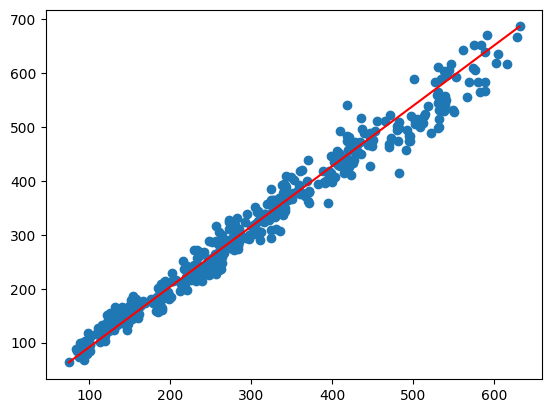

In [143]:
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(y_pred.min(), y_pred.max()), np.linspace(y_test.min(), y_test.max()), color='red')

In [132]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

display(feature_importance_df.head(20))
# forest_importances = pd.Series(importances, index=X_train.columns)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

,Feature,Importance
8,running_mean_4_wk,0.957580
1,week,0.026910
5,sales_5_wk_ago,0.002189
7,sales_7_wk_ago,0.002007
6,sales_6_wk_ago,0.001912
4,sales_4_wk_ago,0.001574
10,running_std_4_wk,0.001165
9,running_median_4_wk,0.001161
2,sales_2_wk_ago,0.001096
3,sales_3_wk_ago,0.001085


#### Forecasting for 6 weeks into the future

Approach 1 - recursive forecasting
- Predict 1 week at a time into the future
- Use predicted sales values for lag columns
- Repeat until 6th week

In [335]:
def smape(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100

In [334]:
def train_model(df, model):
    df = df.copy()

    #preprocessing
    df = (df.pipe(addLagColumns, from_weeks_before=2, num_weeks_lag=7, drop_null_rows=False) #Create lag columns
            .pipe(addFeatures, window_size=[4, 8], mean=True, median=True, stdev=True) # Add mean, median, stdev as required
            .pipe(createDummyCols, dummy_cols=['store','item'], dropcols=False) #One hot encoding
            .pipe(reorderColumns, col_order=['startofweek'])
            .dropna(axis='rows').reset_index(drop=True)
                    )
    
    X_train, y_train = df.drop(['store','item','startofweek', 'sales'], axis=1), df[['sales']]

    logger.info("Training model...")
    model.fit(X_train, y_train)
    logger.info("Model trained!")
    return model

def recursivePredict(df, model, forecast_weeks=6, train=False):

    df = df.pipe(aggregateByWeek, sales_col='sales')

    #Get forecast_weeks + 10 most recent dates
    most_recent_weeks = df['startofweek']\
                            .drop_duplicates()\
                            .nlargest(forecast_weeks+10)\
                            .sort_values(ascending=True)\
                            .to_list()

    #forecast horizon
    cutoff_date = most_recent_weeks[-forecast_weeks]

    #train model
    if train:
        model = train_model(df[df['startofweek'] < cutoff_date], model)

    #Keep up to 10 weeks before to calculate lag vars
    df_backfill = df[(df['startofweek'] >= most_recent_weeks[0]) & 
                    (df['startofweek'] < cutoff_date)].reset_index(drop=True)

    #Dataset for prediction
    df_predict = df[df['startofweek'] >= cutoff_date].reset_index(drop=True)
    df_predict['sales'] = -1 #Set sales after the forecast horizon to -1 for bookkeeping

    logger.info("Making predictions...")
    for week in most_recent_weeks[-forecast_weeks:]:
        #Append the week to be predicted
        df_processed = pd.concat([df_backfill, df_predict[df_predict['startofweek'] == week]], 
                                ignore_index=True, 
                                axis=0)
        
        #Add features
        df_processed = (df_processed.pipe(addLagColumns, from_weeks_before=2, num_weeks_lag=7, drop_null_rows=False) #Create lag columns
                            .pipe(addFeatures, window_size=[4, 8], mean=True, median=True, stdev=True) # Add mean, median, stdev as required
                            .pipe(createDummyCols, dummy_cols=['store','item'], dropcols=False) #One hot encoding
                            .pipe(reorderColumns, col_order=['startofweek'])
                                    )
        
        #Remove all rows except the ones needed for prediction
        df_processed = df_processed[df_processed['startofweek'] == week]

        #Make prediction
        predictions = model.predict(df_processed.drop(['store','item','startofweek', 'sales'], axis=1))
        df_processed['sales'] = predictions

        #Concat to df_backfill to repeat the process
        df_backfill =  pd.concat([df_backfill, 
                                df_processed[['store', 'item', 'startofweek',	'year', 'week', 'sales']]
                                ],
                                ignore_index=True, 
                                axis=0)
        logger.info(f"Week {week} predictions complete")

    results = pd.merge(left=df_backfill[df_backfill['startofweek'] >= cutoff_date]\
                            .astype({'item': 'str', 'store': 'str'}), 
                    right=df.drop('startofweek', axis=1)\
                            .astype({'item': 'str', 'store': 'str'}),
                    how='left',
                    on=['store','item','year','week'],
                    suffixes=('_pred', '_actual')
                    )
    
    #Display metrics
    for week in most_recent_weeks[-forecast_weeks:]:
        y_pred = results[results['startofweek'] == week]['sales_pred']
        y_test = results[results['startofweek'] == week]['sales_actual']
        
        logger.info(f"Week {week}: RMSE - {root_mean_squared_error(y_pred, y_test)}, SMAPE - {smape(y_test, y_pred)}")

    logger.info(f"Overall: RMSE - {root_mean_squared_error(results['sales_pred'], results['sales_actual'])}, SMAPE: {smape(y_test, y_pred)}")

    return results

In [336]:
model=RandomForestRegressor(n_jobs=-1)
predictions = recursivePredict(df=training_dataset, 
                 model=model, 
                 forecast_weeks=12, train=True)
predictions

2025-02-11 13:55:37.859 | INFO     | __main__:train_model:14 - Training model...
c:\Users\Daniel.JosephLim\Documents\demand-forecasting\.venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2025-02-11 13:56:52.898 | INFO     | __main__:train_model:16 - Model trained!
2025-02-11 13:56:52.925 | INFO     | __main__:recursivePredict:45 - Making predictions...
2025-02-11 13:56:54.328 | INFO     | __main__:recursivePredict:72 - Week 2017-10-09 00:00:00 predictions complete
2025-02-11 13:56:56.065 | INFO     | __main__:recursivePredict:72 - Week 2017-10-16 00:00:00 predictions complete
2025-02-11 13:56:58.155 | INFO     | __main__:recursivePredict:72 - Week 2017-10-23 00:00:00 predictions complete
2025-02-11 13:56:59.962 | INFO     | __main__:recursivePredict:72 - Week 2017-10-30 00:00:00 predictions 

,store,item,startofweek,year,week,sales_pred,sales_actual
0,1,1,2017-10-09,2017,41,148.42,147
1,1,2,2017-10-09,2017,41,409.26,382
2,1,3,2017-10-09,2017,41,255.46,245
3,1,4,2017-10-09,2017,41,139.33,171
4,1,5,2017-10-09,2017,41,130.50,117
...,...,...,...,...,...,...,...
5995,10,46,2017-12-25,2017,52,418.97,418
5996,10,47,2017-12-25,2017,52,160.92,135
5997,10,48,2017-12-25,2017,52,363.29,343
5998,10,49,2017-12-25,2017,52,212.86,200


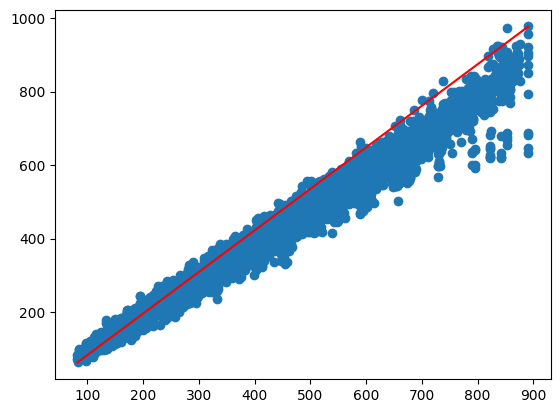

In [326]:
y_pred, y_test = predictions['sales_pred'], predictions['sales_actual']
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(y_pred.min(), y_pred.max()), np.linspace(y_test.min(), y_test.max()), color='red')

In [268]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

display(feature_importance_df.head(20))

,Feature,Importance
8,running_mean_4_wk,0.957690
1,week,0.023656
11,running_mean_8_wk,0.004681
12,running_median_8_wk,0.002314
5,sales_5_wk_ago,0.001227
4,sales_4_wk_ago,0.001174
6,sales_6_wk_ago,0.001090
7,sales_7_wk_ago,0.001081
13,running_std_8_wk,0.001000
2,sales_2_wk_ago,0.000930


Approach 2 - Bulk Forecasting
- Predict 6 weeks at a time into the future

In [318]:
def shiftSalesForward(df, groupby_cols=['store','item'], 
                  sales_col='sales',
                  from_weeks_ahead=1, 
                  num_weeks_shift=3,
                  drop_null_rows=False):

    assert 0 < num_weeks_shift , "num_weeks_shift should be more than 1"

    df = df.copy()

    for i in range(from_weeks_ahead, num_weeks_shift):
        df[f"sales_{i}_wk_ahead"] = df.groupby(by=groupby_cols)[sales_col].shift(-i)
    
    if drop_null_rows:
        df = df.dropna(subset=[f"sales_{i}_wk_ahead"]).reset_index(drop=True)
        
    return df

In [324]:
forecast_weeks=3
training_dataset.pipe(aggregateByWeek, sales_col='sales')\
                .pipe(shiftSalesForward, from_weeks_ahead=1, num_weeks_shift=forecast_weeks, drop_null_rows=False)

,store,item,startofweek,year,week,sales,sales_1_wk_ahead,sales_2_wk_ahead
0,1,1,2012-12-31,2013,1,73,66.0,80.0
1,1,1,2013-01-07,2013,2,66,80.0,70.0
2,1,1,2013-01-14,2013,3,80,70.0,86.0
3,1,1,2013-01-21,2013,4,70,86.0,82.0
4,1,1,2013-01-28,2013,5,86,82.0,80.0
...,...,...,...,...,...,...,...,...
130495,10,50,2017-11-27,2017,48,482,453.0,470.0
130496,10,50,2017-12-04,2017,49,453,470.0,442.0
130497,10,50,2017-12-11,2017,50,470,442.0,432.0
130498,10,50,2017-12-18,2017,51,442,432.0,NaN


In [337]:
def bulkPredict(df, model, forecast_weeks=6, train=False):

    df = df.pipe(aggregateByWeek, sales_col='sales')

    #Get forecast_weeks x 2 most recent dates
    most_recent_weeks = df['startofweek']\
                            .drop_duplicates()\
                            .nlargest(2*forecast_weeks)\
                            .sort_values(ascending=True)\
                            .to_list()


    train_cutoff_date, test_cutoff_date = most_recent_weeks[0], most_recent_weeks[-forecast_weeks]

    df_processed = (df \
                        .pipe(addLagColumns, from_weeks_before=2, num_weeks_lag=7, drop_null_rows=False) #Create lag columns
                        .pipe(shiftSalesForward, from_weeks_ahead=1, num_weeks_shift=forecast_weeks, drop_null_rows=False)
                        .pipe(addFeatures, window_size=[4, 8], mean=True, median=True, stdev=True) # Add mean, median, stdev as required
                        .pipe(createDummyCols, dummy_cols=['store','item'], dropcols=False) #One hot encoding
                        .pipe(reorderColumns, col_order=['startofweek'])
                        .dropna(axis='rows').reset_index(drop=True)
                            )

    train_set = df_processed[df_processed['startofweek'] <= train_cutoff_date]
    test_set = df_processed[df_processed['startofweek'] == test_cutoff_date]

    #Train model
    if train:
        logger.info("Training model...")
        model.fit(train_set.drop(['store','item','startofweek', 'sales']+\
                                [f"sales_{i}_wk_ahead" for i in range(1, forecast_weeks)], axis=1),
                train_set[['sales']+\
                            [f"sales_{i}_wk_ahead" for i in range(1, forecast_weeks)]]
                            )

        logger.info("Model trained!")

    #Predict
    logger.info("Making predictions...")
    predictions = model.predict(test_set.drop(['store','item','startofweek', 'sales']+\
                                            [f"sales_{i}_wk_ahead" for i in range(1, forecast_weeks)], 
                                            axis=1))

    for i in range(forecast_weeks):
        colname = "sales" if i == 0 else f"sales_{i}_wk_ahead"
        test_set[colname] = predictions[:,i]

    def formatPredictions(predictions, actual):

        predictions = predictions.melt(id_vars=["store", "item", "startofweek"], var_name='sales_type', value_name="sales_qty")

        # Adjust the startofweek column based on sales_type
        predictions["startofweek"] = predictions["startofweek"] + predictions["sales_type"].apply(
                    lambda x: pd.Timedelta(weeks=int(x.split('_')[1])) if 'sales_' in x else pd.Timedelta(weeks=0))

        #Cleanup
        predictions = predictions\
            .drop(columns=["sales_type"])\
            .dropna()\
            .rename(columns={"sales_qty" : "sales"})
        
        #Merge with actual dataset
        results =  pd.merge(left=predictions\
                                .astype({'item': 'str', 'store': 'str'}), 
                        right=actual\
                                .astype({'item': 'str', 'store': 'str'}),
                        how='left',
                        on=['store','item','startofweek'],
                        suffixes=('_pred', '_actual')
                        )
    
        return results[['startofweek', 'store', 'item', 'year', 'week', 'sales_pred', 'sales_actual']]

    results = formatPredictions(predictions=test_set[['startofweek', 'store', 'item', 'sales']+\
                                                    [f"sales_{i}_wk_ahead" for i in range(1, forecast_weeks)]],
                                actual=df[df['startofweek'] >= test_cutoff_date]
                                )

    #Display metrics
    for week in most_recent_weeks[-forecast_weeks:]:
        y_pred = results[results['startofweek'] == week]['sales_pred']
        y_test = results[results['startofweek'] == week]['sales_actual']
        
        logger.info(f"Week {week}: RMSE - {root_mean_squared_error(y_pred, y_test)}, SMAPE - {smape(y_test, y_pred)}")

    logger.info(f"Overall: RMSE - {root_mean_squared_error(results['sales_pred'], results['sales_actual'])}, SMAPE: {smape(y_test, y_pred)}")
    
    return results


In [338]:
model=RandomForestRegressor(n_jobs=-1)
predictions = bulkPredict(df=training_dataset, 
                 model=model, 
                 forecast_weeks=12, train=True)
predictions

2025-02-11 14:09:28.687 | INFO     | __main__:bulkPredict:29 - Training model...
2025-02-11 14:10:24.530 | INFO     | __main__:bulkPredict:36 - Model trained!
2025-02-11 14:10:24.532 | INFO     | __main__:bulkPredict:39 - Making predictions...
C:\Users\Daniel.JosephLim\AppData\Local\Temp\ipykernel_48044\2211250770.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[colname] = predictions[:,i]
2025-02-11 14:10:24.832 | INFO     | __main__:bulkPredict:84 - Week 2017-10-09 00:00:00: RMSE - 22.64920981844621, SMAPE - 5.086272021928213
2025-02-11 14:10:24.837 | INFO     | __main__:bulkPredict:84 - Week 2017-10-16 00:00:00: RMSE - 21.967435931396274, SMAPE - 4.829732749240683
2025-02-11 14:10:24.843 | INFO     | __main__:bulkPredict:84 - Week

,startofweek,store,item,year,week,sales_pred,sales_actual
0,2017-10-09,1,1,2017,41,150.12,147
1,2017-10-09,1,2,2017,41,411.73,382
2,2017-10-09,1,3,2017,41,251.29,245
3,2017-10-09,1,4,2017,41,138.44,171
4,2017-10-09,1,5,2017,41,132.70,117
...,...,...,...,...,...,...,...
5995,2017-12-25,10,46,2017,52,373.85,418
5996,2017-12-25,10,47,2017,52,147.39,135
5997,2017-12-25,10,48,2017,52,338.80,343
5998,2017-12-25,10,49,2017,52,190.77,200


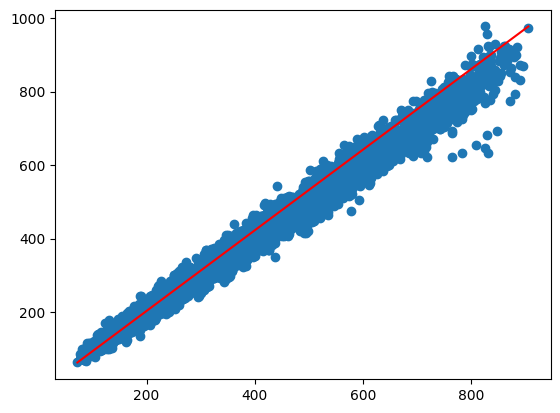

In [332]:
y_pred, y_test = predictions['sales_pred'], predictions['sales_actual']
plt.scatter(y_pred, y_test)
plt.plot(np.linspace(y_pred.min(), y_pred.max()), np.linspace(y_test.min(), y_test.max()), color='red')

#### Observations
- Bulk prediction seems to work better than recursive prediction for long forecast horizons
- Recursive prediction has slightly better RMSE for first 1 or 2 weeks